# Taller Fourier EDM - Clasificación de cargas de electrodomésticos

## Práctica 4 - Clasificación de cargas

### Objetivos:
En esta práctica se busca clasificar las cargas en los distintos tipos de electrodomésticos. Partiendo de las señales I y V se extraen características de las cargas y se ensayan varios clasificadores

### Actividades

1. Extracción de características  
A partir de las señales V e I de una carga, se extraen diversas características a usar en la clasificación. 

2. Prueba de distintos clasificadores

3. Evaluación de resultados  
Como se vio en la práctica 1, la base de señales usada tiene señales de diversos tipos de electrodomésticos adquiridas en distintas casas. Para evaluar los resultados de la clasificación se realizará validación cruzada con el esquema "dejar uno afuera". En este esquema se entrena un clasificador con los datos de N-1 casas y se clasifican las señales de la casa restante. Esto se repite para todos los casos y se reportan los resultados de "acierto promedio" y matriz de confusión.


### Materiales

Se usa una base de referencia de señales V-I correspondiente a once tipos distintos de electrodomésticos ('Air Conditioner', 'Compact Fluorescent Lamp', 'Fan', 'Fridge', 'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Laptop', 'Microwave', 'Vacuum', 'Washing Machine'). La base está disponible en http://www.plaidplug.com/, [1].

Las señales, de 2 a 5 segundos de duración, están en archivos ".csv" donde la primera columna es la intensidad y la segunda columna es el voltaje.  
La frecuencia de línea de las señales es $F_l=60Hz$.  
La frecuencia de muestreo de las señales es $F_s=30kHz$.

[1] Gao, Jingkun, et al. "Plaid: a public dataset of high-resoultion electrical appliance measurements for load identification research: demo abstract." proceedings of the 1st ACM Conference on Embedded Systems for Energy-Efficient Buildings. ACM, 2014.

### Datos

La base de datos PLAID se baja de  http://www.plaidplug.com/.   

El archivo "meta1_simple.csv" en la carpeta "data" tiene tres columnas con la información sobre las señales de los electrodomésticos.   
Columnas:  
* identificador del electrodoméstico
* código del tipo del electrodoméstico
* identificador de la casa donde se registró la señal

Los tipos de electrodomésticos son  [código, nombre]:  
* 0: 'Air Conditioner',
* 1: 'Compact Fluorescent Lamp',
* 2: 'Fan',
* 3: 'Fridge',
* 4: 'Hairdryer',
* 5: 'Heater',
* 6: 'Incandescent Light Bulb',
* 7: 'Laptop',
* 8: 'Microwave',
* 9: 'Vacuum',
* 10: 'Washing Machine'

Por ejemplo, las señales I,V en el archivo '10.csv' corresponde al electrodoméstico con id=10, tipo=8 (Microwave) y de la casa=1.

![You won!!](./data/won-the-trophy-smiley-emoticon.gif "You won!!")

### Uso de funciones de la práctica 1.

En esta práctica usaremos las funciones creadas en la práctica 1.  
Para eso se copiarán las funciones a un archivo **funciones_practica_1.py** dentro 
del directorio **funciones**.  


Para poder usar las funciones se importarán con:  
**from funciones.funciones_practica_1 import * **



### Trabajo a realizar

A lo largo del notebook encontraran las siguientes palabras claves:

* \# COMPLETAR  -> indica que se requiere completar el código. 
  
  
* \# EXPERIMENTAR -> indica que la celda contiene código funcional que permite experimentar variando el tipo de electrodoméstico, parámetros de las funciones, etc. Es posible, si lo requiere la experimentación duplicar la celda y realizar los cambio que sean de interés en el código.
  
  
* \# DISCUTIR -> se espera una discusión de los experimentos realizados y/o de las preguntas formuladas
  
  
  
* \# RESPONDER -> se espera una respuesta a preguntas concretas

In [1]:
import os
import numpy as np
from scipy.fftpack import fft, fftshift, ifft
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from datetime import datetime

# autoreload. Los cambios en modulos externos como 'funciones_practica_1.py' se recargan automaticamente
%load_ext autoreload
%autoreload 2

# importar las funciones de la práctica 1
from funciones.funciones_practica_1 import *

# importar funciones utiles
from funciones.util import plot_confusion_matrix

#estilo de las gráficas
plt.style.use('ggplot')


# graficas en línea  entre las celdas
#%matplotlib inline 
# graficas en línea  entre las celdas con pan/zoom
%matplotlib notebook
# graficas en ventanas externas
# %matplotlib




In [2]:
# importar funciones del módulo de aprendizaje sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier as RF, AdaBoostClassifier as ABC

## Parte 1 - Carga de los datos

In [3]:
frecuencia_muestreo = 30000 #Frecuencia de muestreo en Hz
frecuencia_linea = 60    #Frecuencia de línea en Hz
muestras_por_ciclo = int(frecuencia_muestreo/frecuencia_linea)

nombres_electrodomesticos = ['Air Conditioner', 
                         'Compact Fluorescent Lamp',
                         'Fan',
                         'Fridge',
                         'Hairdryer',
                         'Heater',
                         'Incandescent Light Bulb',
                         'Laptop',
                         'Microwave',
                         'Vacuum',
                         'Washing Machine']

nombres_abreviados_electrodomesticos = ['AirC','CFL','Fan','Frid','Hair','Heat','ILB','Lapt','MWave','Vacc','Wash']

# ubicación del directorio  de la base PLAID que contiene los ".csv"
PLAID_csv_directory = "C:/Users/carlos/Downloads/PLAID/CSV"

# archivo con la metadata
archivo_metadata = './data/meta1_simple.csv'


### 1.1 Testear las funciones de carga de meta-datos

In [4]:
# Testeos. Permite verificar que se cargan bien las funciones de la práctica 1

print('-------------------------------------------------------------') 
# Imprimir la cantidad de electrodomesticos en la base
print('Cantidad de electrodomésticos en la base:', get_cantidad_electrodomesticos() )

print('-------------------------------------------------------------') 
# Imprimir lista de tipos y nombres
for i in range(len(nombres_electrodomesticos)):
    print('{}:{}'.format(i,nombres_electrodomesticos[i]))

    
print('-------------------------------------------------------------') 
# Imprimir datos de un cierto electrodoméstico
id_elec = 10
print("Id electrodoméstico: {}".format(id_elec) )
print("Archivo: {}".format(get_nombre_archivo(id_elec)) )
print("Tipo: {}:{}".format(get_tipo(id_elec), get_nombre(id_elec)) )
print("Casa: {}".format(get_casa(id_elec)))
print('-------------------------------------------------------------')   


print('-------------------------------------------------------------') 
# Imprimir datos de un cierto tipo de electrodomésticos
tipo = np.random.choice(len(nombres_electrodomesticos))
ids = get_ids_por_tipo(tipo)

print('Electrodomésticos tipo {}:{}'.format(tipo, nombres_electrodomesticos[tipo]))
print(ids)

print('Un electrodoméstico de este tipo ---------------')
id_elec = np.random.choice(ids)
print("Id electrodoméstico: {}".format(id_elec) )
print("Archivo: {}".format(get_nombre_archivo(id_elec)) )
print("Tipo: {}:{}".format(get_tipo(id_elec), get_nombre(id_elec)) )
print("Casa: {}".format(get_casa(id_elec)))

print('-------------------------------------------------------------') 
# Imprimir datos de una cierta casa
casa = 17
ids = get_ids_por_casa(casa)

print('Electrodomésticos de la casa {}'.format(casa))
print(ids)



-------------------------------------------------------------
Cantidad de electrodomésticos en la base: 1074
-------------------------------------------------------------
0:Air Conditioner
1:Compact Fluorescent Lamp
2:Fan
3:Fridge
4:Hairdryer
5:Heater
6:Incandescent Light Bulb
7:Laptop
8:Microwave
9:Vacuum
10:Washing Machine
-------------------------------------------------------------
Id electrodoméstico: 10
Archivo: C:/Users/carlos/Downloads/PLAID/CSV/10.csv
Tipo: 8:Microwave
Casa: 1
-------------------------------------------------------------
-------------------------------------------------------------
Electrodomésticos tipo 0:Air Conditioner
[15, 16, 17, 38, 39, 40, 83, 84, 85, 86, 87, 160, 161, 162, 163, 164, 288, 289, 290, 291, 292, 365, 366, 367, 368, 374, 375, 376, 377, 378, 394, 395, 396, 397, 398, 423, 424, 425, 426, 427, 428, 449, 450, 451, 452, 453, 513, 514, 515, 516, 517, 784, 785, 786, 787, 788, 985, 986, 987, 988, 989, 1006, 1007, 1008, 1009, 1010]
Un electrodoméstico

## Parte 2. Extracción de características

### 2.1 Calcular las características  dadas por la función **calcular_potencia_IEEE_1459_2010** para todos los electrodomésticos.  

Se usarán los datos de régimen descartando el inicio de las señales que contiene el  transitorio de arranque. El transitorio es variable en la base dependiendo del electrodoméstico y de la adquisición particular. Para la práctica pueden considerar que el transitorio dura un largo fijo para todas las señales ( algo entre 0.25 segundos (15 ciclos) y 1 segundo (60 ciclos) ) que determinaran por inspección de las señales). 

Se obtendrán tres arrays:
* **DATOS_IEEE** de tamaño **[cant_electrodomesticos x 14]**
* **TIPO** de tamaño **[cant_electrodomesticos x 1]** con el tipo (numérico) de cada electrodoméstico de la base
* **CASA** de tamaño **[cant_electrodomesticos x 1]** con la casa correspondiente a cada electrodoméstico de la base


Cada fila del array **DATOS_IEEE** son 14 características **[S, S_11, S_H, S_N, P, P_11, P_H, Q_11, D_I, D_V, D_H, N, THD_V, THD_I]** que hemos calculado a partir de las señales I,V de un electrodoméstico. 

Los elementos del array **TIPO** representan la etiqueta "real" de cada electrodoméstico. 

Los elementos del array **CASA** indican los subconjuntos en los que se agrupan los electrodomésticos.

Con las etiquetas, las características calculadas y la información de subconjuntos entrenaremos nuestros clasificadores y también evaluaremos la performance de los mismos.


In [5]:
# COMPLETAR
# Calcular las características dadas por la
# función calcular_potencia_IEEE_1459_2010 

ids = get_ids()

# inicializar arrays
TIPO=np.empty( (len(ids)), dtype=np.uint8)
CASA = np.empty( (len(ids)), dtype=np.uint8)
DATOS_IEEE=np.empty( (len(ids), 14))
            
for i in range(len(ids)):
    id_elec = ids[i][0]          
    print('Calculando {:04d}/{:04d}'.format(id_elec, len(ids)), end='\r', flush=True)
    
    #COMPLETAR código
    I,V = cargar_VI_por_ciclos(get_nombre_archivo(id_elec), 
                               ciclos_a_saltear=50,
                               ciclos_a_cargar=60)
    
    S, S_11, S_H, S_N, P, P_11, P_H, Q_11, D_I, D_V, D_H, N, THD_V, THD_IR = \
            calcular_potencia_IEEE_1459_2010(I,V, frecuencia_muestreo=30000, frecuencia_linea=60)
    
    TIPO[i] = get_tipo(id_elec)
    CASA[i] = get_casa(id_elec)
    DATOS_IEEE[i,0] = S
    DATOS_IEEE[i,1] = S_11
    DATOS_IEEE[i,2] = S_H
    DATOS_IEEE[i,3] = S_N
    DATOS_IEEE[i,4] = P
    DATOS_IEEE[i,5] = P_11
    DATOS_IEEE[i,6] = P_H
    DATOS_IEEE[i,7] = Q_11
    DATOS_IEEE[i,8] = D_I
    DATOS_IEEE[i,9] = D_V
    DATOS_IEEE[i,10] = D_H
    DATOS_IEEE[i,11] = N
    DATOS_IEEE[i,12] = THD_V
    DATOS_IEEE[i,13] = THD_IR
    
    

### 2.2 Calcular el factor de potencia fundamental y el factor de potencia total

Estas son otras características derivadas de las calculadas en 2.1  

Se obtendrán dos arrays:
* **FP_fun** de tamaño **[cant_electrodomesticos x 1]**
* **FP_tot** de tamaño **[cant_electrodomesticos x 1]**



In [6]:
# COMPLETAR
# Calcular las características FP_fun y FP_tot

FP_fun = np.empty(len(ids))
FP_tot = np.empty(len(ids))

for i in range(len(ids)):
    id_elec = ids[i][0]          
    print('Calculando {:04d}/{:04d}'.format(id_elec, len(ids)), end='\r', flush=True)
    
    FP_fun[i] = DATOS_IEEE[i,5] / DATOS_IEEE[i,1] # FP_fun = P_11/S_11
    FP_tot[i] = DATOS_IEEE[i,4] / DATOS_IEEE[i,0] # FP_tot = P/S
    
    

### 2.3 Analizar características: realizar histogramas y box-plot de las características

Elegir tres características de las 16 que se han calculado al momento y realizar histogramas y/o box-plot de las mismas.

<IPython.core.display.Javascript object>


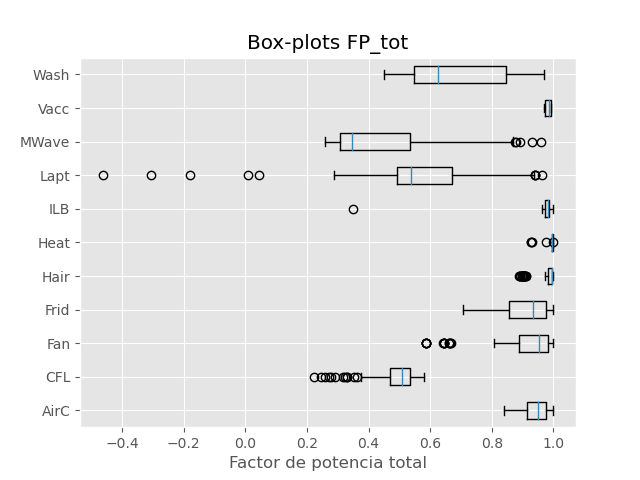

<IPython.core.display.Javascript object>


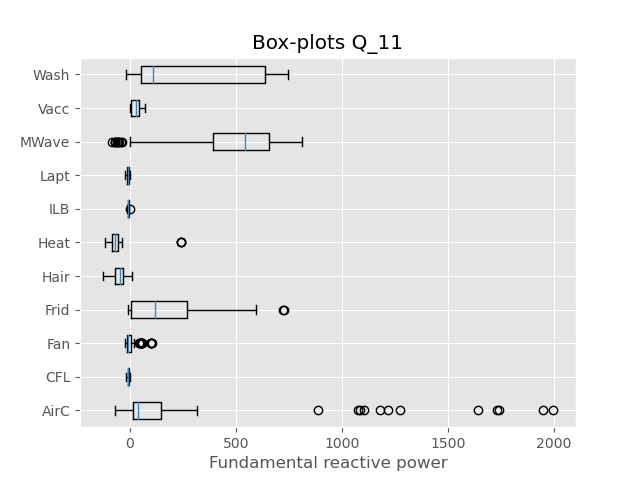

<IPython.core.display.Javascript object>


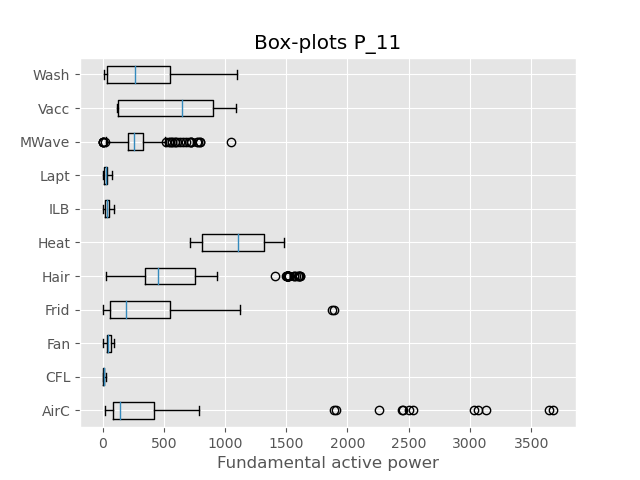

<function matplotlib.pyplot.close(fig=None)>

In [10]:
# COMPLETAR
# Histogramas y/o box-plot

FP_tot_por_tipo = []
Q11_por_tipo = []
P11_por_tipo = []
for i in range(len(nombres_electrodomesticos)):
    aux1 = []
    aux2 = []
    aux3 = []
    for j in get_ids_por_tipo(i):
        aux1.append(FP_tot[j-1])
        aux2.append(DATOS_IEEE[j-1,7])
        aux3.append(DATOS_IEEE[j-1,5])
    FP_tot_por_tipo.append(aux1)
    Q11_por_tipo.append(aux2)
    P11_por_tipo.append(aux3)
    

plt.figure()
plt.title("Box-plots FP_tot")
plt.xlabel("Factor de potencia total")
plt.boxplot(FP_tot_por_tipo, vert=False, labels=nombres_abreviados_electrodomesticos)
plt.close
                    
plt.figure()
plt.title("Box-plots Q_11")
plt.xlabel("Fundamental reactive power")
plt.boxplot(Q11_por_tipo, vert=False, labels=nombres_abreviados_electrodomesticos)
plt.close
                    
plt.figure()
plt.title("Box-plots P_11")
plt.xlabel("Fundamental active power")
plt.boxplot(P11_por_tipo, vert=False, labels=nombres_abreviados_electrodomesticos)
plt.close


## Parte 3. Clasificación. Entrenamiento y validación cruzada


### 3.1 Entrenamiento y validación cruzada

Como se vio en la práctica 1, la base de señales usada tiene señales de diversos tipos de electrodomésticos adquiridas en distintas casas (N=55 casas). Para entrenar y evaluar los resultados de la clasificación se realizará validación cruzada con el esquema "dejar uno afuera". En este esquema se entrena un clasificador con los datos de N-1 casas y se clasifican las señales de la casa restante. Esto se repite para todos los casos y se reportan los resultados de "acierto promedio" y matriz de confusión.

La función **clasificar** recibe
* un clasificador, 
* las características a utilizar, 
* las etiquetas,
* los indicadores de subconjunto o "fold" en que se agrupan los datos.

En nuestro caso, 
* Como clasificador se usará alguno de los disponibles en sklearn (K vecinos más cercanos, Random Forest, etc.)
* Las características serán algunas de las calculadas en la parte 2 que se pasarán en un array de tamaño  **[cant_electrodomésticos x cant_características]**  
* Las etiquetas serán los tipos de los electrodomésticos en un array de tamaño **[cant_electrodomesticos x 1]**
* Los indicadores de subconjunto serán las casas a las que pertenecen los electrodomésticos como un array de tamaño **[cant_electrodomesticos x 1]**

In [11]:
# COMPLETAR
# Comentar adecuadamente el código  
# No es necesario modificar el código 

def clasificar(clasificador, caracteristicas, etiquetas, subconjuntos ):
    '''
    Recibe un clasificador ya creado, las caracteristicas, 
    las etiquetas y los indicadores de subconjuntos. 
    Devuelve las tasas de acierto y las predicciones
    '''
    
    # Si se usa una sóla característica, forzar que sea un vector columna
    if caracteristicas.ndim == 1:
        caracteristicas = caracteristicas[:,np.newaxis]
    
    # Guarda la cantidad de subconjuntos distintos
    cantidad_subconjuntos = len(np.unique(subconjuntos))
    
    # Crea un array vacío del largo de cantidad de subconjuntos distintos
    accuracies = np.empty((cantidad_subconjuntos))
    # Crea un array vacío de la cantidad de elementos a clasificar
    y_predictions = np.empty((caracteristicas.shape[0]), dtype=np.uint8)
    
    # Guarda la hora actual (t=0)
    start = datetime.now()
    
    # Para cada subconjunto
    for i in range(cantidad_subconjuntos):
        # Selecciona un subconjunto
        id_subconjunto = np.unique(subconjuntos)[i]
        print('%d/%d fold...\t tiempo: %ds'%(id_subconjunto,cantidad_subconjuntos,(datetime.now()-start).seconds), end='\r', flush=True)

        # Guarda los índices de las casas del subconjunto seleccionado
        indices_test = np.where(subconjuntos==id_subconjunto)[0]
        # Guarda los índices de las casas que no pertenecen al subconjunto seleccionado
        indices_train = np.where(subconjuntos!=id_subconjunto)[0]

        # Guarda las caracteristicas de los elementos que no pertencen al subconjunto seleccionado
        X_train = caracteristicas[indices_train,:]
        # Guarda las etiquetas de los elementos que no pertenecen al subconjunto seleccionado
        y_train = etiquetas[indices_train]

        # Idem para el subconjunto seleccionado
        X_test = caracteristicas[indices_test,:]
        y_test = etiquetas[indices_test]

        # Se asocian las características de entrenamiento con las etiquetas correspondientes (Método de SciKit)
        clf = clasificador # Solo un nombre más corto
        clf.fit(X_train,y_train)

        # Se hace una predicción de que etiquetas corresponden a los datos de testeo
        y_pred = clf.predict(X_test)
        # Se le pone valor a la predicción (Qué tan buena es)
        acc = clf.score(X_test,y_test)

        # Agrega la precisión de las predicciones en base al subconjunto seleccionado 
        # a un arreglo de precisiones.
        accuracies[i] = acc
        # Guarda las predicciones para cada elemento del subconjunto actual 
        y_predictions[indices_test] = y_pred
    
    return accuracies, y_predictions


def mostrar_performance(accuracies, y_predictions, etiquetas):
    print('Acierto medio = {:.2f}'.format(np.mean(accuracies)*100))

    # Convierte los arreglos de predicciones y las etiquetas en enteros
    y_pred = y_predictions.astype(int)
    y_test = etiquetas.astype(int)

    # Grafica la matriz de confusion
    plot_confusion_matrix(y_test, y_pred, 
                          classes=nombres_electrodomesticos,
                          title='Matriz de confusión')
    

## Parte 4. Clasificador de K vecinos más cercanos (K-NN)

### 4.1 Resumir los principales aspectos del clasificador de K vecinos más cercanos

\# RESPONDER

* Para cada elemento a clasificar, se buscan los k elementos de entrenamiento que estén a menor distancia del elemento a clasificar. Se clasifica en la categoría que tenga más elementos cerca del elemento a clasificar. 
* Es simple y bastante rápido.
* Funciona mal si la cantidad de vecinos no es la adecuada. 

### 4.2 Experimentar variando características y parámetros del clasificador

A) Experimentar usando características de a una, o en conjuntos. Por ejemplo
* FP_fun
* FP_tot
* TDH_I
* DATOS_IEEE
* Todas juntas

Para juntar características se puede usar las funciones np.hstack y np.vstack. Verificar que quede un array de tamaño [cant_electrodomésticos x cant_características]


B) Experimentar variando la cantidad de vecinos del clasificador

C) Realizar una tabla que resuma los resultados obtenidos  

In [12]:
# EXPERIMENTAR 

cantidad_de_vecinos = 13
clasificador = KNN(n_neighbors=cantidad_de_vecinos)


#caracteristicas = FP_tot
#caracteristicas = DATOS_IEEE[:,12:]
#caracteristicas = DATOS_IEEE[:,:]
#factores = np.transpose(np.vstack((FP_fun, FP_tot)))
#todas_juntas = np.hstack((factores, DATOS_IEEE))
#caracteristicas = todas_juntas
#print(caracteristicas.shape)


#accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
#mostrar_performance(accuracies, y_predictions, TIPO)

tabla = np.zeros((4,7))
iteraciones_vecinos = np.arange(3,17,2)

for i in range(7):
    cantidad_de_vecinos = iteraciones_vecinos[i]
    clasificador = KNN(n_neighbors=cantidad_de_vecinos)
    
    #Factor de potencia total
    caracteristicas = FP_tot
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[0,i] = np.mean(accuracies)*100
    
    #THD
    caracteristicas = DATOS_IEEE[:,12:]
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[1,i] = np.mean(accuracies)*100
    
    #Todos IEEE
    caracteristicas = DATOS_IEEE[:,:]
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[2,i] = np.mean(accuracies)*100
    
    #IEEE + Factores de potencia
    factores = np.transpose(np.vstack((FP_fun, FP_tot)))
    todas_juntas = np.hstack((factores, DATOS_IEEE))
    caracteristicas = todas_juntas
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[3,i] = np.mean(accuracies)*100


from pandas import DataFrame

print(DataFrame(tabla, columns=iteraciones_vecinos))

          3          5          7          9          11         13         15
0  46.182112  45.084206  46.728500  47.653759  48.516507  49.922535  47.411993
1  49.729568  49.660164  49.992223  49.782126  48.247785  48.729997  49.128658
2  77.551435  76.821155  76.867493  75.662310  73.460575  72.060626  70.262505
3  77.733254  76.821155  76.867493  75.662310  73.460575  72.060626  70.262505


Clasificador: KNN
Acierto medio = 70.26
Confusion matrix, without normalization
[[ 29   0  12   1   7   1   9   0   0   7   0]
 [  0 152   0   0   0   0   0  23   0   0   0]
 [ 13   1  65   0   0   0  26   0   0   0  10]
 [ 12   1   6   5   4   1   4   0   1   4   0]
 [  5   0   0   0 123  17   1   0   0  10   0]
 [  0   0   0   0  22   5   0   0   0   8   0]
 [  0   1   9   0   0   0 104   0   0   0   0]
 [  0  26  12   0   0   0   4 130   0   0   0]
 [  0   2   7   0   7   0   0   4 118   1   0]
 [ 15   0   0   0   5   5   0   0   0  13   0]
 [  5   0   9   0   1   0   0   0   6   2   3]]


<IPython.core.display.Javascript object>


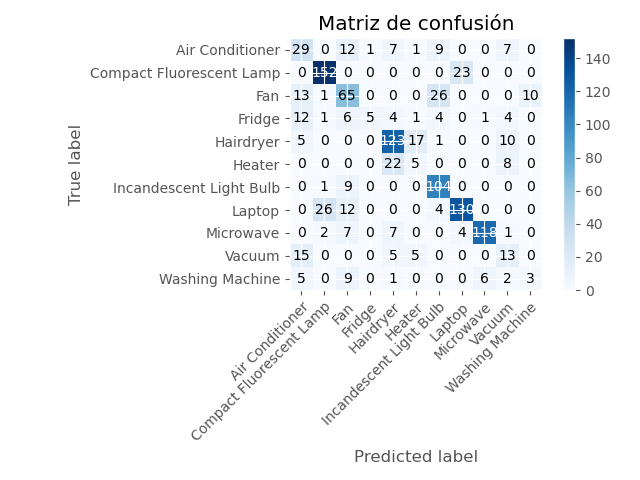

In [13]:
# Performance

%matplotlib notebook
print('Clasificador: KNN')
mostrar_performance(accuracies, y_predictions, TIPO)

## Parte 5. Otros clasificadores

Experimentar con algún otro clasificador. 

Repetir lo realizado en la parte 4.

Realizar una tabla resumen de resultados y comparar con el clasificador de K-NN.

In [157]:
# EXPERIMENTAR

#clasificador = RF()

#caracteristicas = FP_tot
#caracteristicas = DATOS_IEEE[:,1:5]
#factores = np.transpose(np.vstack((FP_fun, FP_tot)))
#todas_juntas = np.hstack((factores, DATOS_IEEE))
#caracteristicas = todas_juntas
#print(caracteristicas.shape)

#accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)

tabla = np.zeros((4,7))
iteraciones_arboles = np.arange(25,200,25)


for i in range(7):
    arboles = iteraciones_arboles[i]
    clasificador = RF(n_estimators=arboles)
    
    #Factor de potencia total
    caracteristicas = FP_tot
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[0,i] = np.mean(accuracies)*100
    
    #THD
    caracteristicas = DATOS_IEEE[:,12:]
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[1,i] = np.mean(accuracies)*100
    
    #Todos IEEE
    caracteristicas = DATOS_IEEE[:,:]
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[2,i] = np.mean(accuracies)*100
    
    #IEEE + Factores de potencia
    factores = np.transpose(np.vstack((FP_fun, FP_tot)))
    todas_juntas = np.hstack((factores, DATOS_IEEE))
    caracteristicas = todas_juntas
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[3,i] = np.mean(accuracies)*100


from pandas import DataFrame

print(DataFrame(tabla, columns=iteraciones_arboles))


         25         50         75         100        125        150        175
0  40.009562  40.106323  40.015414  40.027535  40.015414  40.015414  40.015414
1  50.277710  48.741525  50.907532  49.948226  49.279097  49.038591  48.478729
2  79.956707  80.574711  80.499930  78.927875  79.640716  80.034463  80.020774
3  83.276407  82.221536  82.584252  82.794404  83.239988  82.659666  83.320429


Clasificador: LDA
Acierto medio = 70.26
Confusion matrix, without normalization
[[ 29   0  12   1   7   1   9   0   0   7   0]
 [  0 152   0   0   0   0   0  23   0   0   0]
 [ 13   1  65   0   0   0  26   0   0   0  10]
 [ 12   1   6   5   4   1   4   0   1   4   0]
 [  5   0   0   0 123  17   1   0   0  10   0]
 [  0   0   0   0  22   5   0   0   0   8   0]
 [  0   1   9   0   0   0 104   0   0   0   0]
 [  0  26  12   0   0   0   4 130   0   0   0]
 [  0   2   7   0   7   0   0   4 118   1   0]
 [ 15   0   0   0   5   5   0   0   0  13   0]
 [  5   0   9   0   1   0   0   0   6   2   3]]


<IPython.core.display.Javascript object>


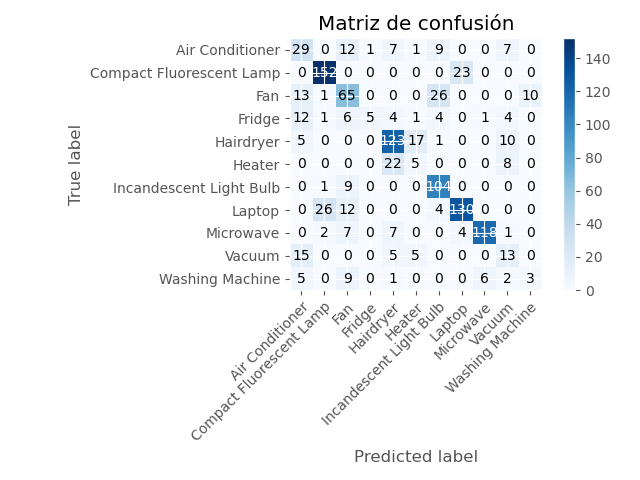

In [14]:
# Performance

%matplotlib notebook
print('Clasificador: LDA')
mostrar_performance(accuracies, y_predictions, TIPO)

## Parte 6. Prueba de otras características 

Las características usadas hasta el momento surgen de cálculos sobre las señales que se programaron en la práctica 1.  

También se observó en dicha práctica que el diagrama VI de cada tipo de  electrodoméstico tiene una forma típica. 

En esta parte se usará la forma del diagrama VI como característica para clasificar. 

### 6.1  Función que dados V e I devuelve una imagen del diagrama VI

In [8]:
# VI IMAGE
#
# Adaptado de:  
# [1] Gao, Jingkun, et al. "Plaid: a public dataset of high-resoultion 
# electrical appliance measurements for load identification research: 
# demo abstract." proceedings of the 1st ACM Conference on Embedded 
# Systems for Energy-Efficient Buildings. ACM, 2014.
# 

def get_img_from_VI(V, I, width, hard_threshold=False, para=.5):
    '''Get images from VI, hard_threshold, set para as threshold to cut off,5-10
    soft_threshold, set para to .1-.5 to shrink the intensity'''
    
    d = V.shape[0]
    # doing interploation if number of points is less than width*2
    if d<2* width:
        newV = np.hstack([V, V[0]])
        newI = np.hstack([I, I[0]])
        oldt = np.linspace(0,d,d+1)
        newt = np.linspace(0,d,2*width)
        I = np.interp(newt,oldt,newI)
        V = np.interp(newt,oldt,newV)
    # get the size resolution of mesh given width
    d_c = (np.amax(I) - np.amin(I)) / width
    d_v = (np.amax(V) - np.amin(V)) / width
    
    #  find the index where the VI goes through in current-voltage axis
    ind_c = np.floor((I-np.amin(I))/d_c).astype(int)
    ind_v = np.floor((V-np.amin(V))/d_v).astype(int)
    ind_c[ind_c==width] = width-1
    ind_v[ind_v==width] = width-1  # ok
    
    Img = np.zeros((width,width))
    
    for i in range(len(I)):
        Img[ind_c[i],width-ind_v[i]-1] += 1 # why backwards?
    
    if hard_threshold:
        Img[Img<para] = 0
        Img[Img!=0] = 1
        return Img
    else:
        return (Img/np.max(Img))**para

### 6.2 Mostrar imágenes  de diagramas 

<IPython.core.display.Javascript object>


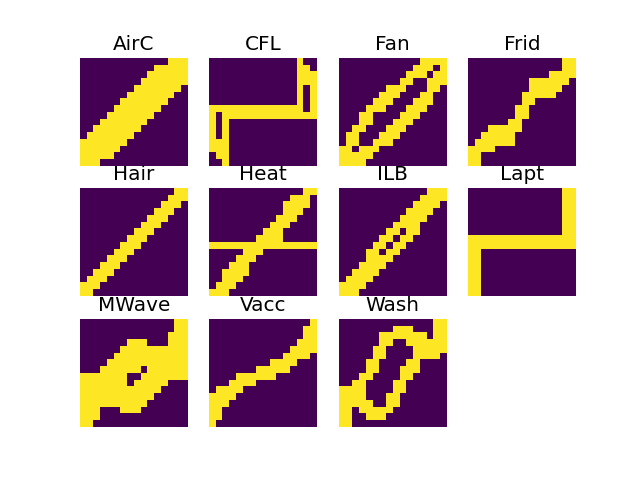

(0.0, 1.0, 0.0, 1.0)

In [16]:
# COMPLETAR
# Mostrar en un subplot las imágenes para los distintos tipos de electrodomésticos
# 
# ancho_imagen_VI = 16
# hard_threshold = True


subplot_rows = 3
subplot_cols = 4
ancho_imagen_VI = 16
hard_th = True


# COMPLETAR código

fig, axs = plt.subplots(subplot_rows, subplot_cols)

for t in range(len(nombres_electrodomesticos)):
    ids = get_ids_por_tipo(t)
    nombre_de_archivo = get_nombre_archivo(ids[0])
    I,V = cargar_VI_por_ciclos(nombre_de_archivo, ciclos_a_saltear=50)
    #ciclo_I, ciclo_V = get_ciclo_I_V_promedio_alineado(I,V)

    axs[t // subplot_cols , t % subplot_cols].imshow(get_img_from_VI(V,I, width=ancho_imagen_VI, hard_threshold=hard_th))
    axs[t // subplot_cols , t % subplot_cols].set_title(nombres_abreviados_electrodomesticos[t])
    axs[t // subplot_cols , t % subplot_cols].axis("off")

axs[subplot_rows-1,subplot_cols-1].axis("off")   

### 6.3 Clasificar usando la imagen como característica


#### 6.3.1 Calcular las características

Calcular un array **IMG_VI** de tamaño **[cant_electrodomesticos x (ancho_imagen_VI^2)]** donde cada fila es la imagen (pasada a una dimensión recorriendo por filas) del diagrama VI del correspondiente electrodoméstico. 

Usar para las imágenes de VI:
* ancho_imagen_VI = 16
* hard_threshold = True


In [17]:
# COMPLETAR
# Calcular el array IMG_VI  [cant_electrodomesticos x (ancho_imagen_VI^2)] 
# 

ancho_imagen_VI = 16
hard_th = True

ids = get_ids()

# inicializar arrays
IMG_VI = np.empty( (len(ids), ancho_imagen_VI**2))
            
# COMPLETAR código

for i in ids:
    nombre_de_archivo = get_nombre_archivo(i[0])
    I,V = cargar_VI_por_ciclos(nombre_de_archivo, ciclos_a_saltear=50)
    IMG_VI[i-1,:] = np.ravel(get_img_from_VI(V,I, width=ancho_imagen_VI, hard_threshold=hard_th))
    
    print('Calculando {:04d}/{:04d}'.format(int(i), len(ids)), end='\r', flush=True)


In [18]:
print(IMG_VI.shape)

(1074, 256)


#### 6.3.2 Clasificar y ver performance

In [19]:
# EXPERIMENTAR
# Clasificar con la imagen del diagrama VI como característica

clasificador = RF(n_estimators=100)

caracteristicas = IMG_VI

accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)


Clasificador: RF
Acierto medio = 82.45
Confusion matrix, without normalization
[[ 49   0   2   1   6   4   0   3   1   0   0]
 [  0 154   0   0   3   0   0  18   0   0   0]
 [  6   0  69   0  10   5  22   2   0   0   1]
 [  4   1   4  19   2   1   3   2   0   1   1]
 [  3   0   5   1 144   3   0   0   0   0   0]
 [  5   0   4   0  18   8   0   0   0   0   0]
 [  1   3   5   2   2   0 100   1   0   0   0]
 [  4   3   0   0   0   0   0 165   0   0   0]
 [  0   3   0   1   0   0   0   5 130   0   0]
 [  0   0   0   0   0   0   0   0   0  38   0]
 [  2   0   0   8   0   0   0   2   2   0  12]]


<IPython.core.display.Javascript object>


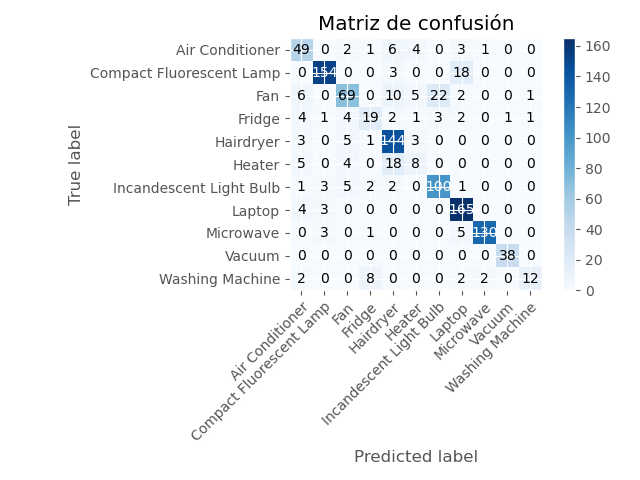

In [20]:
# Performance

%matplotlib notebook
print('Clasificador: RF')
mostrar_performance(accuracies, y_predictions, TIPO)

#### 6.3.3 Probar con otros tamaños de imagen y/o umbral suave

In [9]:
# EXPERIMENTAR 

ancho_imagen_VI = 16
hard_th = False

ids = get_ids()

# inicializar arrays
IMG_VI_soft = np.empty( (len(ids), ancho_imagen_VI**2))

for i in ids:
    nombre_de_archivo = get_nombre_archivo(i[0])
    I,V = cargar_VI_por_ciclos(nombre_de_archivo, ciclos_a_saltear=50)
    IMG_VI_soft[i-1,:] = np.ravel(get_img_from_VI(V,I, width=ancho_imagen_VI, hard_threshold=hard_th))
    
    print('Calculando {:04d}/{:04d}'.format(int(i), len(ids)), end='\r', flush=True)


## Parte 7. Competencia 

Buscar la mejor performance medida en terminos del acierto medio. Algunas de las cosas que se pueden probar:
* Distintos clasificadores y parámetros
* Juntar las características calculadas a lo largo de la práctica.
* Introducir nuevas características. 
* Identificar los tipos que se confunden y buscar estrategias para discriminar mejor entre esos tipos



### Importantes premios para los ganadores  !!!!!! 
![alt text](data/won-the-trophy-smiley-emoticon.gif "Vamo' arriba") 




### Combinamos todas las características y las imagenes, e hicimos un RF con n=150

In [22]:
clasificador = RF(n_estimators=150)
#clasificador = KNN(3)

factores = np.transpose(np.vstack((FP_fun, FP_tot)))
todas_juntas = np.hstack((factores, DATOS_IEEE))
caracteristicas = np.hstack((todas_juntas, IMG_VI))

accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)



Clasificador: RF, Características: Todas
Acierto medio = 85.70
Confusion matrix, without normalization
[[ 49   0  11   2   2   0   1   0   1   0   0]
 [  0 161   0   0   0   0   0  14   0   0   0]
 [  9   0  87   5   0   0  13   1   0   0   0]
 [  8   1   2  21   1   0   4   1   0   0   0]
 [  0   0   1   1 152   2   0   0   0   0   0]
 [  0   0   0   0  24  10   0   0   1   0   0]
 [  0   0   7   2   0   0 104   1   0   0   0]
 [  1  10   1   0   0   0   0 160   0   0   0]
 [  0   3   0   0   1   0   0   2 133   0   0]
 [  0   0   0   0   0   0   0   0   0  38   0]
 [  5   0   1   6   0   0   0   0   1   0  13]]


<IPython.core.display.Javascript object>


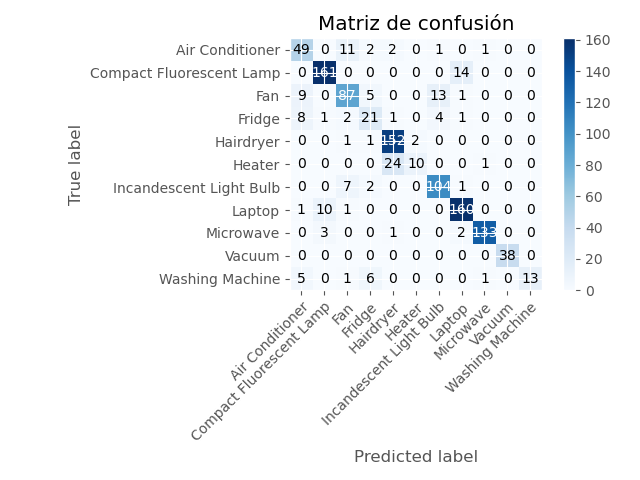

In [24]:
# Performance

%matplotlib notebook
print('Clasificador: RF, Características: Todas')
mostrar_performance(accuracies, y_predictions, TIPO)

In [31]:
# TABLAS

iteraciones_vecinos = np.array([1, 2, 3, 5, 7, 10, 13, 15, 21, 23, 30, 50, 70, 100])
tabla = np.zeros((5,iteraciones_vecinos.shape[0]))


for i in range(iteraciones_vecinos.shape[0]):
    cantidad_de_vecinos = iteraciones_vecinos[i]
    clasificador = KNN(n_neighbors=cantidad_de_vecinos)
    
    #Factor de potencia total
    caracteristicas = FP_tot
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[0,i] = int(round(np.mean(accuracies)*100))
    
    #THD
    caracteristicas = DATOS_IEEE[:,12:]
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[1,i] = int(round(np.mean(accuracies)*100))
    
    #Todos IEEE
    caracteristicas = DATOS_IEEE[:,:]
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[2,i] = int(round(np.mean(accuracies)*100))
    
    #IEEE + Factores de potencia
    factores = np.transpose(np.vstack((FP_fun, FP_tot)))
    todas_juntas = np.hstack((factores, DATOS_IEEE))
    caracteristicas = todas_juntas
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[3,i] = int(round(np.mean(accuracies)*100))
    
    # TODOS
    caracteristicas = np.hstack((todas_juntas, IMG_VI_soft))
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[4,i] = int(round(np.mean(accuracies)*100))

from pandas import DataFrame

print(DataFrame(tabla, columns=iteraciones_vecinos))


    1     2     3     5     7     10    13    15    21    23    30    50   \
0  40.0  41.0  46.0  45.0  47.0  48.0  50.0  47.0  50.0  49.0  49.0  51.0   
1  48.0  48.0  50.0  50.0  50.0  49.0  49.0  49.0  49.0  48.0  49.0  51.0   
2  76.0  77.0  78.0  77.0  77.0  75.0  72.0  70.0  68.0  67.0  69.0  65.0   
3  76.0  77.0  78.0  77.0  77.0  75.0  72.0  70.0  68.0  67.0  69.0  65.0   
4  78.0  78.0  78.0  77.0  77.0  75.0  72.0  70.0  67.0  67.0  69.0  65.0   

    70    100  
0  50.0  48.0  
1  52.0  53.0  
2  61.0  56.0  
3  61.0  56.0  
4  61.0  56.0  


<IPython.core.display.Javascript object>


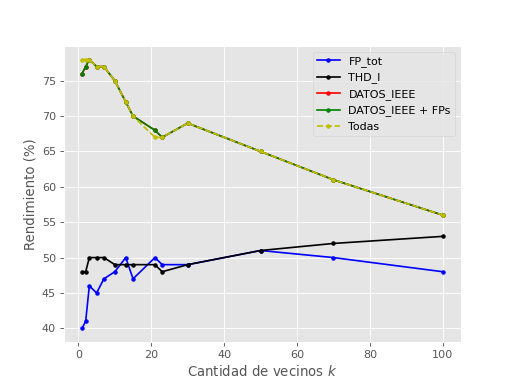

Text(0.5, 0, 'Cantidad de vecinos $k$')

In [49]:
plt.plot(iteraciones_vecinos, tabla[0,:], 'b.-')
plt.plot(iteraciones_vecinos, tabla[1,:], 'k.-')
plt.plot(iteraciones_vecinos, tabla[2,:], 'r.-')
plt.plot(iteraciones_vecinos, tabla[3,:], 'g.-')
plt.plot(iteraciones_vecinos, tabla[4,:], 'y.--')
plt.legend(['FP_tot', 'THD_I', 'DATOS_IEEE', 'DATOS_IEEE + FPs', 'Todas'])
plt.ylabel("Rendimiento (%)")
plt.xlabel("Cantidad de vecinos $k$")

In [53]:
# TABLAS

iteraciones_arboles = np.array([1, 5, 10, 15, 50, 100, 125, 150, 200, 250, 300])
tabla = np.zeros((5,iteraciones_arboles.shape[0]))


for i in range(iteraciones_arboles.shape[0]):
    cantidad_de_arboles = iteraciones_arboles[i]
    clasificador = RF(n_estimators=cantidad_de_arboles)
    
    #Factor de potencia total
    caracteristicas = FP_tot
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[0,i] = int(round(np.mean(accuracies)*100))
    
    #THD
    caracteristicas = DATOS_IEEE[:,12:]
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[1,i] = int(round(np.mean(accuracies)*100))
    
    #Todos IEEE
    caracteristicas = DATOS_IEEE[:,:]
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[2,i] = int(round(np.mean(accuracies)*100))
    
    #IEEE + Factores de potencia
    factores = np.transpose(np.vstack((FP_fun, FP_tot)))
    todas_juntas = np.hstack((factores, DATOS_IEEE))
    caracteristicas = todas_juntas
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[3,i] = int(round(np.mean(accuracies)*100))
    
    # TODOS
    caracteristicas = np.hstack((todas_juntas, IMG_VI_soft))
    accuracies, y_predictions = clasificar(clasificador, caracteristicas, TIPO, CASA)
    tabla[4,i] = int(round(np.mean(accuracies)*100))



In [54]:
print(DataFrame(tabla, columns=iteraciones_arboles))

    1     5     10    15    50    100   125   150   200   250   300
0  41.0  41.0  40.0  42.0  40.0  40.0  40.0  40.0  40.0  40.0  40.0
1  45.0  46.0  50.0  49.0  49.0  49.0  49.0  50.0  49.0  49.0  48.0
2  73.0  76.0  77.0  81.0  80.0  80.0  80.0  80.0  81.0  81.0  80.0
3  72.0  81.0  81.0  83.0  83.0  83.0  83.0  83.0  84.0  83.0  83.0
4  69.0  80.0  82.0  83.0  85.0  84.0  85.0  85.0  85.0  85.0  84.0


<IPython.core.display.Javascript object>


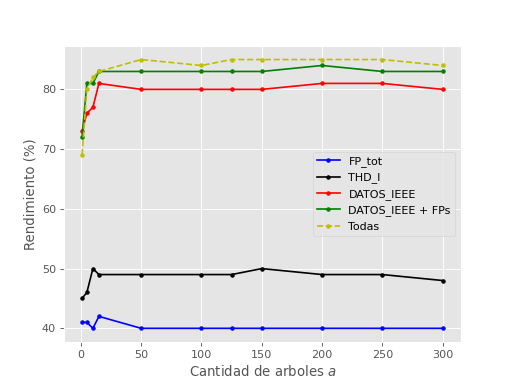

Text(0.5, 0, 'Cantidad de arboles $a$')

In [55]:
plt.figure()
plt.plot(iteraciones_arboles, tabla[0,:], 'b.-')
plt.plot(iteraciones_arboles, tabla[1,:], 'k.-')
plt.plot(iteraciones_arboles, tabla[2,:], 'r.-')
plt.plot(iteraciones_arboles, tabla[3,:], 'g.-')
plt.plot(iteraciones_arboles, tabla[4,:], 'y.--')
plt.legend(['FP_tot', 'THD_I', 'DATOS_IEEE', 'DATOS_IEEE + FPs', 'Todas'])
plt.ylabel("Rendimiento (%)")
plt.xlabel("Cantidad de arboles $a$")